In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#my imports
import env
import os
import wrangle as w
import explore as e

In [2]:
#Get my data
df = w.acquire_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   propertylandusetypeid         52441 non-null  float64
 2   typeconstructiontypeid        76 non-null     float64
 3   storytypeid                   47 non-null     float64
 4   airconditioningtypeid         13638 non-null  float64
 5   architecturalstyletypeid      70 non-null     float64
 6   buildingclasstypeid           0 non-null      float64
 7   heatingorsystemtypeid         33935 non-null  float64
 8   id                            52441 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52441 non-null  float64
 11  bedroomcnt                    52441 non-null  float64
 12  buildingqualitytypeid         33740 non-null  float64
 13  c

In [4]:
df = w.prepare_zillow(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50709 entries, 0 to 52440
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   parcel_id                 50709 non-null  int64  
 1   propertylandusetypeid     50709 non-null  float64
 2   basement_sqft             50709 non-null  float64
 3   bath_count                50709 non-null  float64
 4   bed_count                 50709 non-null  float64
 5   calc_bath_and_bed         50709 non-null  float64
 6   decktypeid                50709 non-null  float64
 7   calc_sqft                 50709 non-null  float64
 8   finished_sqft12           50709 non-null  float64
 9   fips                      50709 non-null  float64
 10  fireplace_cnt             50709 non-null  float64
 11  full_bath_cnt             50709 non-null  float64
 12  has_hot_tub               50709 non-null  float64
 13  latitude                  50709 non-null  float64
 14  longit

In [6]:
#Ensuring no nulls are present
df.isna().sum().sum()

0

In [7]:
df.head().T

,0,1,2,3,4
parcel_id,14297519,17052889,14186244,12177905,12095076
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,3.5,1.0,2.0,3.0,3.0
bed_count,4.0,2.0,3.0,4.0,4.0
calc_bath_and_bed,3.5,1.0,2.0,3.0,3.0
decktypeid,0.0,0.0,0.0,0.0,0.0
calc_sqft,3100.0,1465.0,1243.0,2376.0,2962.0
finished_sqft12,3100.0,1465.0,1243.0,2376.0,2962.0
fips,6059.0,6111.0,6059.0,6037.0,6037.0


In [ ]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

add_upper_outlier_columns(df, k=1.5)

df.head()

In [ ]:
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

In [ ]:
def create_features(df):
    df['age'] = 2017 - df.year_built
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.tax_amount/df.tax_value*100

    # create acres variable
    df['acres'] = df.lot_sqft/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calc_sqft, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structure_tax_value/df.calc_sqft


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.land_value/df.lot_sqft

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bath_count/df.bed_count

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['region_id_city'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df

In [8]:
df = e.create_features(df)

In [9]:
df.head().T

,0,1,2,3,4
parcel_id,14297519,17052889,14186244,12177905,12095076
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,3.5,1.0,2.0,3.0,3.0
bed_count,4.0,2.0,3.0,4.0,4.0
calc_bath_and_bed,3.5,1.0,2.0,3.0,3.0
decktypeid,0.0,0.0,0.0,0.0,0.0
calc_sqft,3100.0,1465.0,1243.0,2376.0,2962.0
finished_sqft12,3100.0,1465.0,1243.0,2376.0,2962.0
fips,6059.0,6111.0,6059.0,6037.0,6037.0


In [ ]:
def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['region_id_county'])
    return df_dummies

In [10]:
df = e.get_counties(df)

In [11]:
df.head().T

,0,1,2,3,4
parcel_id,14297519,17052889,14186244,12177905,12095076
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,3.5,1.0,2.0,3.0,3.0
bed_count,4.0,2.0,3.0,4.0,4.0
calc_bath_and_bed,3.5,1.0,2.0,3.0,3.0
decktypeid,0.0,0.0,0.0,0.0,0.0
calc_sqft,3100.0,1465.0,1243.0,2376.0,2962.0
finished_sqft12,3100.0,1465.0,1243.0,2376.0,2962.0
fips,6059.0,6111.0,6059.0,6037.0,6037.0


In [12]:
train, validate, test = w.train_validate_test_split(df)

In [13]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura
41103,17242283,261.0,0.0,2.0,4.0,2.0,0.0,1580.0,1580.0,6111.0,...,0.4,107.997468,0.4,29.229979,0.3,0.5,0,0,0,1
20357,12137554,261.0,0.0,3.0,3.0,3.0,0.0,2636.0,2636.0,6037.0,...,0.6,130.312974,0.4,32.385867,0.3,1.0,0,1,0,0
6488,11306071,261.0,0.0,4.0,5.0,4.0,0.0,4497.0,4497.0,6037.0,...,0.8,83.411163,0.3,5.440878,0.2,0.8,0,1,0,0
32580,11317604,261.0,0.0,3.0,5.0,3.0,0.0,2870.0,2870.0,6037.0,...,0.6,62.539373,0.2,8.546714,0.2,0.6,0,1,0,0
3506,14050673,261.0,0.0,2.0,4.0,2.0,0.0,1493.0,1493.0,6059.0,...,0.3,54.464166,0.2,85.894591,0.4,0.5,0,0,1,0


In [14]:
#Make bins for log error
train['logerror_bins'] = pd.cut(train.log_error, [-5, -.2, -.05, .05, .2, 4])

In [15]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins
41103,17242283,261.0,0.0,2.0,4.0,2.0,0.0,1580.0,1580.0,6111.0,...,107.997468,0.4,29.229979,0.3,0.5,0,0,0,1,"(-0.05, 0.05]"
20357,12137554,261.0,0.0,3.0,3.0,3.0,0.0,2636.0,2636.0,6037.0,...,130.312974,0.4,32.385867,0.3,1.0,0,1,0,0,"(-0.2, -0.05]"
6488,11306071,261.0,0.0,4.0,5.0,4.0,0.0,4497.0,4497.0,6037.0,...,83.411163,0.3,5.440878,0.2,0.8,0,1,0,0,"(-0.2, -0.05]"
32580,11317604,261.0,0.0,3.0,5.0,3.0,0.0,2870.0,2870.0,6037.0,...,62.539373,0.2,8.546714,0.2,0.6,0,1,0,0,"(-0.05, 0.05]"
3506,14050673,261.0,0.0,2.0,4.0,2.0,0.0,1493.0,1493.0,6059.0,...,54.464166,0.2,85.894591,0.4,0.5,0,0,1,0,"(-0.05, 0.05]"


In [16]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    22988
(0.05, 0.2]       5714
(-0.2, -0.05]     4293
(0.2, 4.0]        1640
(-5.0, -0.2]       839
Name: logerror_bins, dtype: int64

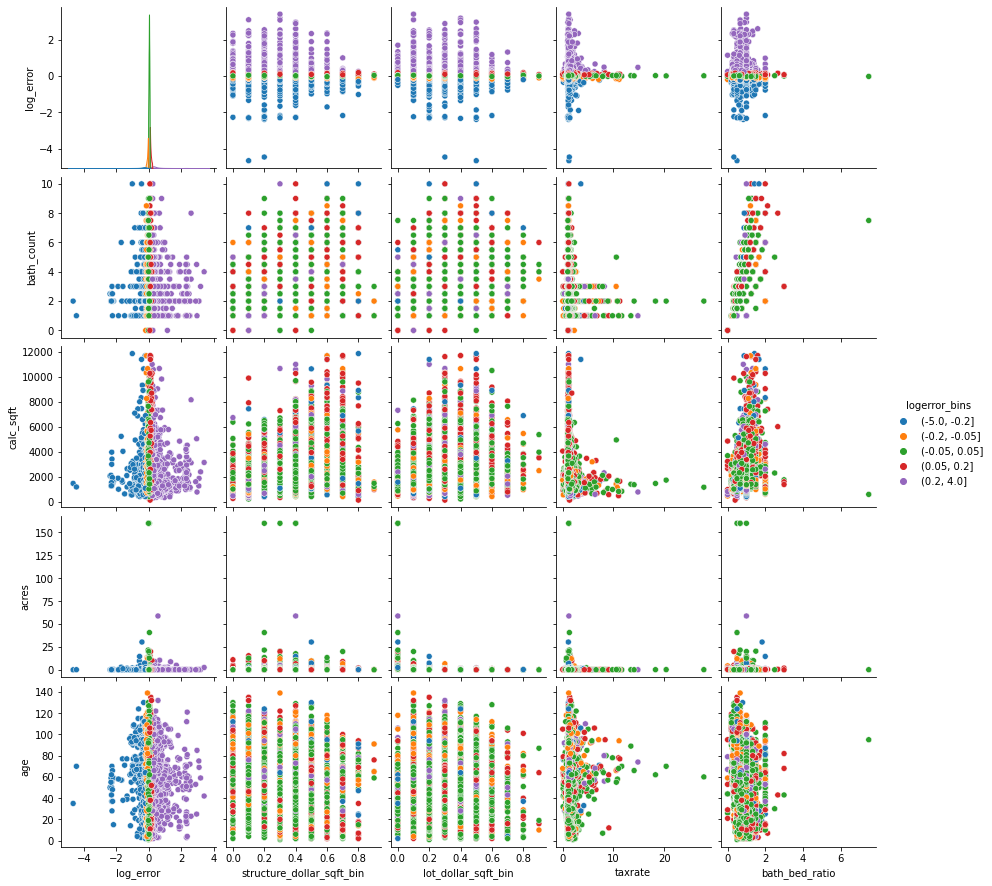

In [17]:
#Pairplot for log error bins
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['log_error', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['log_error', 'bath_count', 'calc_sqft', 'acres', 'age'])

In [ ]:
train.head().T

In [ ]:
train.bath_bed_ratio.isnull().value_counts()

In [ ]:
#Scaling variables
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['latitude', 'longitude', 'age'],return_scaler=False):
    '''This function takes in train, validate, test, and outputs scaled data based on
    the chosen method (quantile scaling) using the columns selected as the only columns
    that will be scaled. This function also returns the scaler object as an array if set 
    to true'''
    # make copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
     # select a scaler
    scaler = MinMaxScaler()
     # fit on train
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [ ]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age', 'bath_bed_ratio'])

In [ ]:
train_scaled.head()

In [ ]:
X = train_scaled[['latitude'
]]
X = iris[['petal_length', 'sepal_length']]
